# PyTorch를 이용한 AutoEncoder 구현하기
## MLP (Multi-Layer Perceptron) 구조 vs CNN (Convolutional Neural Network) 구조

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from tqdm import tqdm

## 하이퍼파라미터 설정하기

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 5

## torchvision.datasets을 이용하여 MNIST 데이터셋 로드하기

In [3]:
mnist_train = dset.MNIST(
    root="./data", 
    train=True, 
    transform=transforms.ToTensor(), 
    target_transform=None, 
    download=True
)
mnist_test = dset.MNIST(
    root="./data", 
    train=False, 
    transform=transforms.ToTensor(), 
    target_transform=None, 
    download=True
)

## torch.utils.data.DataLoader를 이용하여 PyTorch 데이터로더 생성하기

In [4]:
train_loader = torch.utils.data.DataLoader(
    dataset=mnist_train,
    batch_size=batch_size, 
    shuffle=True,
    num_workers=2,
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=mnist_test,
    batch_size=batch_size, 
    shuffle=False,
    num_workers=2,
    drop_last=True
)

## MLP 기반의 오토인코더 구조 생성하기

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 28*28),
            nn.ReLU(),
            nn.BatchNorm1d(28*28),

            nn.Linear(28*28, 14*14),
            nn.ReLU(),
            nn.BatchNorm1d(14*14),

            nn.Linear(14*14, 14*14),
            nn.ReLU(),
            nn.BatchNorm1d(14*14),

            nn.Linear(14*14, 7*7),
            nn.ReLU(),
            nn.BatchNorm1d(7*7),
        )
        self.decoder = nn.Sequential(
            nn.Linear(7*7, 14*14),
            nn.ReLU(),
            nn.BatchNorm1d(14*14),

            nn.Linear(14*14, 14*14),
            nn.ReLU(),
            nn.BatchNorm1d(14*14),

            nn.Linear(14*14, 28*28),
            nn.ReLU(),
            nn.BatchNorm1d(28*28),

            nn.Linear(28*28, 28*28),
            nn.ReLU()
        )
                
    def forward(self,x):
        x = x.view(batch_size,-1)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(batch_size,1,28,28)
        return out

## 원하는 Device (ex: GPU)에 모델 올리고 학습을 위한 준비하기

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


cuda:0


## 학습하기 (tqdm을 이용하여 학습 진행상황 모니터링 하기)

In [7]:
loss_arr =[]
for i in range(num_epoch):
    for image,label in tqdm(train_loader, desc="Epoch: "+str(i+1)):
        x = image.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,x)
        loss.backward()
        optimizer.step()
       


Epoch: 5: 100%|██████████| 234/234 [00:08<00:00, 28.16it/s]


## 학습결과 모니터링하기 (학습 데이터셋을 이용)



torch.Size([256, 28, 28])


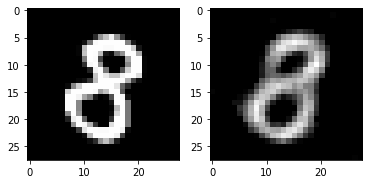

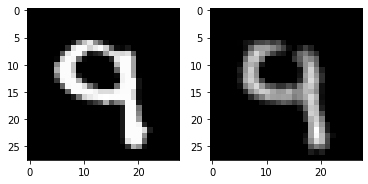

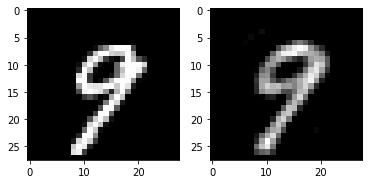

In [8]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(3):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

## 학습결과 모니터링하기 (테스트 데이터셋을 이용)

In [9]:
with torch.no_grad():
  for i in range(1):
      for j,[image,label] in enumerate(test_loader):
          x = image.to(device)

          optimizer.zero_grad()
          output = model.forward(x)

      if j % 1000 == 0:
          print(loss)        

torch.Size([256, 28, 28])


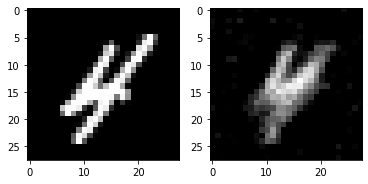

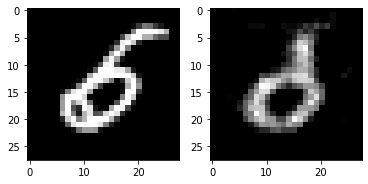

In [10]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(2):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()